<a href="https://colab.research.google.com/github/AnthonyYoussef98/PublicRepo/blob/main/CLIP_Image_Generation_and_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Content

This notebook contains code that showcases how CLIP can be used with a VGAN to be able to be used as an image generator (only provide text as an input), and image editor (provide a text and an initial image to start from ), and an image fusion (provide a text if needed and both and initial and influential image )

# Installing Libraries needed

Downloading Files: You can save some of them locally instead

In [ ]:
print("Downloading CLIP...") 
#Folder CLIP
!git clone https://github.com/openai/CLIP                 &> /dev/null

print("Downloading Ai Transformers Libraries...")
#Taming Trasnformers 
!git clone https://github.com/CompVis/taming-transformers &> /dev/null

#No folders need to keep downloading 
!pip install ftfy regex tqdm omegaconf pytorch-lightning  &> /dev/null
!pip install kornia                                       &> /dev/null
!pip install einops                                       &> /dev/null
!pip install wget                                         &> /dev/null

print("Downloading Metadata Handling Libraries...")
#No folders need to keep downloading 
!pip install stegano                                      &> /dev/null
!apt install exempi                                       &> /dev/null
!pip install python-xmp-toolkit                           &> /dev/null
!pip install imgtag                                       &> /dev/null
!pip install pillow==7.1.2                                &> /dev/null

print("Downloading ImageNet 16384 model...")
#vqgan_imagenet_f16_16384.ckpt
#vqgan_imagenet_f16_16384.yaml
!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384

!mkdir steps  # To create the folder if needed 
# !rm -r steps # To remove the folder if needed 
!rm -r sample_data # To remove the folder if needed 


# Functions Libraries and Definitions

There is an errors in the code so we must create a folder called steps if it is not created for the code to function

the code below will fill this folder and will create an image called progress.png to be updated

In [ ]:
#@title Functions, Libraries, and Classes

#Imports
import argparse
import math
from pathlib import Path
import sys
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
 #Functions
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
  
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
replace_grad = ReplaceGrad.apply
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
clamp_with_grad = ClampWithGrad.apply
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        print(config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return

def CLIP_VQGAN_INPUTS(text = "None",initial_image = "None",influential_image = "None",image_interval = 50,max_iterarion = 300):
  text = text 
  initial_image = initial_image
  influential_image = influential_image

  model_name = "vqgan_imagenet_f16_16384"
  image_interval = image_interval
  max_iterarion = max_iterarion
  input_images = ""

  model_set={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 
                  "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR", "ade20k":"ADE20K", "ffhq":"FFHQ", "celebahq":"CelebA-HQ", "gumbel_8192": "Gumbel 8192"}
  nombre_modelo = model_set[model_name]     

  is_gumbel = False

  if initial_image == "None":
      initial_image = None
  elif initial_image and initial_image.lower().startswith("http"):
      initial_image = download_img(initial_image)


  if influential_image == "None" or not influential_image:
      influential_image = []
  else:
      influential_image = influential_image.split("|")
      influential_image = [image.strip() for image in influential_image]

  if initial_image or influential_image != []:
      input_images = True

  text = [frase.strip() for frase in text.split("|")]
  if text == ['']:
      text = []

  args = argparse.Namespace(
      prompts=text,
      image_prompts=influential_image,
      noise_prompt_seeds=[],
      noise_prompt_weights=[],
      size=[200, 200],
      init_image=initial_image,
      init_weight=0.,
      clip_model='ViT-B/32',
      vqgan_config=f'{model_name}.yaml',
      vqgan_checkpoint=f'{model_name}.ckpt',
      step_size=0.1,
      cutn=64,
      cut_pow=1.,
      display_freq=image_interval,
      seed=None,
  )
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  if text:
      print('Using texts:', text)
  if influential_image:
      print('Using image prompts:', influential_image)
  if args.seed is None:
      seed = torch.seed()
  else:
      seed = args.seed
  torch.manual_seed(seed)
  print('Using seed:', seed)

  model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
  perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

  cut_size = perceptor.visual.input_resolution
  e_dim = model.quantize.e_dim

  f = 2**(model.decoder.num_resolutions - 1)
  make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

  n_toks = model.quantize.n_e

  toksX, toksY = args.size[0] // f, args.size[1] // f
  sideX, sideY = toksX * f, toksY * f

  z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
  z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

  if args.init_image:
      pil_image = Image.open(args.init_image).convert('RGB')
      pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
      z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
  else:
      one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
      z = one_hot @ model.quantize.embedding.weight
      z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
  z_orig = z.clone()
  z.requires_grad_(True)
  opt = optim.Adam([z], lr=args.step_size)

  normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

  pMs = []

  for prompt in args.prompts:
      txt, weight, stop = parse_prompt(prompt)
      embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
      pMs.append(Prompt(embed, weight, stop).to(device))

  for prompt in args.image_prompts:
      path, weight, stop = parse_prompt(prompt)
      img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
      batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
      embed = perceptor.encode_image(normalize(batch)).float()
      pMs.append(Prompt(embed, weight, stop).to(device))

  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
      gen = torch.Generator().manual_seed(seed)
      embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
      pMs.append(Prompt(embed, weight).to(device))
  return max_iterarion, opt, z, model,perceptor,normalize,make_cutouts,args,pMs,nombre_modelo,seed,input_images,z_min,z_max

def synth(z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def add_xmp_data(nombrefichero):
    imagen = ImgTag(filename=nombrefichero)
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
    if args.prompts:
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
    else:
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', nombre_modelo, {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'input_images',str(input_images) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
    imagen.close()

def add_stegano_data(filename):
    data = {
        "title": " | ".join(args.prompts) if args.prompts else None,
        "notebook": "VQGAN+CLIP",
        "i": i,
        "model": nombre_modelo,
        "seed": str(seed),
        "input_images": input_images
    }
    lsb.hide(filename, json.dumps(data)).save(filename)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    add_stegano_data('progress.png')
    add_xmp_data('progress.png')
    display.display(display.Image('progress.png'))

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

    result = []

    if args.init_weight:
        result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    filename = f"steps/{i:04}.png"
    imageio.imwrite(filename, np.array(img))
    add_stegano_data(filename)
    add_xmp_data(filename)
    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

Using device: cuda:0
Using texts: ['fantasy world']
Using seed: 12433335773595678909
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


0it [00:00, ?it/s]

i: 0, loss: 0.890152, losses: 0.890152


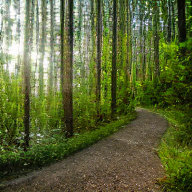

i: 50, loss: 0.765892, losses: 0.765892


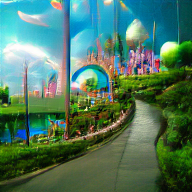

i: 100, loss: 0.735204, losses: 0.735204


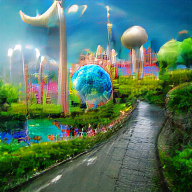

In [ ]:
#@title Execution Block
max_iterarion, opt,z,model,perceptor,normalize,make_cutouts, args,pMs,nombre_modelo,seed,input_images,z_min,z_max = CLIP_VQGAN_INPUTS(text ="fantasy world",image_interval=50,max_iterarion =100)
# add the inputs after text , you want in the line above including initial_image ="im1.jpeg",influential_image  ="im2.jpeg"
#The image shown in the result as i=0 is the image used in as an initial image in this notebook but has been commented out to make sure that the notebook can be run with no prob since u need to upload this pic urself
i = 0
try:
    with tqdm() as pbar:
        while True:
            train(i)
            if i == max_iterarion:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass